# Cross validation

In [1]:
import numpy as np
import pandas as pd
from plotly import express as px
from plotly import graph_objects as go

from mlflow_helper import retrieve, select, organize, get_columns, print_pvalues
from cotrain_helper import LevelOneData, plot_level_one_naive, meta_learn, retrieve_run, retrieve_metrics, retrieve_metrics_all, MetaLearner, get_metrics
import ipdb
breakpoint = ipdb.set_trace

%load_ext autoreload
%autoreload 2

/home/zeyusun/work/flare-prediction-smarp/arnet/constants.py:22: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  CONSTANTS = get_constants()


## Test set uncertainty

In [2]:
runs_raw = retrieve('cv', 'cv')
columns = get_columns('arnet')
columns.update({
    'params.DATA.VAL_SPLIT': 'split'
})
runs = select(runs_raw, columns=columns)
# runs['split'] = runs['split'].astype('int')
runs.style.background_gradient(axis=0)

Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
221 2021-09-09 17:32:31.575000+00:00                  cv


In [3]:
df = organize(runs)#, std=True)
df.style.background_gradient(axis=1)

In [4]:
print_pvalues(runs, 'sharp')
print_pvalues(runs, 'smarp')

Is fused_sharp better than sharp?
LSTM
ACC (0.025088368160064364, 0.490593095429663)
AUC (2.516549624593615, 0.032798769525484675)
TSS (0.02509157358986326, 0.4905918938662893)
HSS (0.025089943028717945, 0.490592505086196)
BSS (1.0336587935323727, 0.17984623406438557)
CNN
ACC (0.706102551921302, 0.25953990219303363)
AUC (-0.30912408100883776, 0.6136702240925566)
TSS (0.7061024239426572, 0.25953993797217856)
HSS (0.706102296580651, 0.2595399735789329)
BSS (0.36885154076782606, 0.3654661101961417)
Is fused_smarp better than smarp?
LSTM
ACC (1.1580955024068524, 0.15563095615857203)
AUC (-0.3250905080781693, 0.6192972275979135)
TSS (1.158096083349692, 0.15563085042316988)
HSS (1.1580970165027955, 0.15563068058333182)
BSS (2.2875430758784634, 0.042042191144288185)
CNN
ACC (1.4414043877457194, 0.11145839726626189)
AUC (2.4949495061595925, 0.03356400802567984)
TSS (1.4414038980591257, 0.11145846179615958)
HSS (1.4414036742024925, 0.11145849129554125)
BSS (2.6286650672084098, 0.029133815997784

## CV sensitivity
Test set prediction sensitivity to the selection of validation fold

### LSTM

In [123]:
members = [
    'cv/cv/fused_sharp/0/0/LSTM',
    '////1/',
    '////2/',
    '////3/',
    '////4/',
]

levelone = LevelOneData(members, get_train=False)

dict_values(['cv', 'cv', 'fused_sharp', '0', '0', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '1', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '2', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '3', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '4', 'LSTM'])


In [124]:
df_train_list = [dfs['train'] for dfs in levelone.dfs]
df_val_list = [dfs['val'] for dfs in levelone.dfs]
df_test_list = [dfs['test'] for dfs in levelone.dfs]
df_test_prob = pd.concat([df['prob'].rename(f'prob{i}')
                          for i, df in enumerate(df_test_list)], axis=1)

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



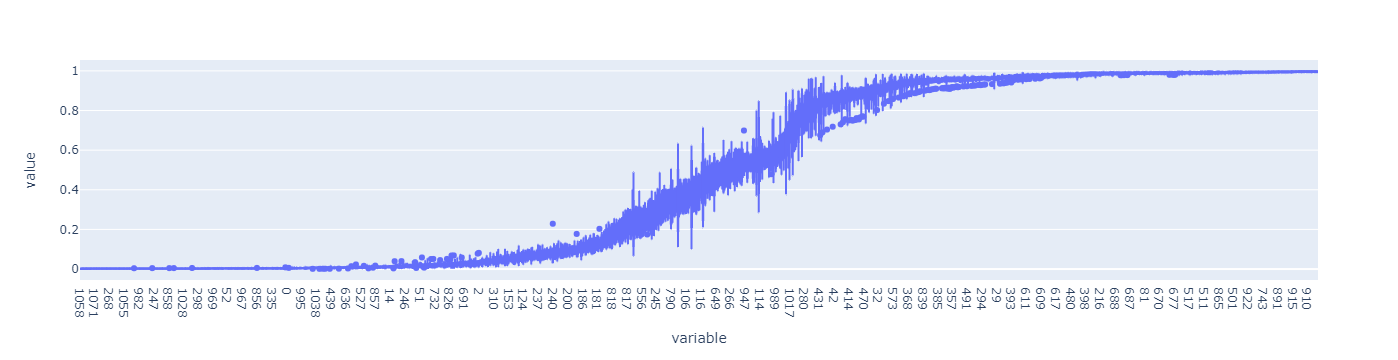

In [125]:
df_box = (df_test_prob
          .assign(mean=df_test_prob.mean(axis=1))
          .sort_values(by='mean')
          .drop(columns=['mean'])
          .transpose())
px.box(df_box) #jitter=False)

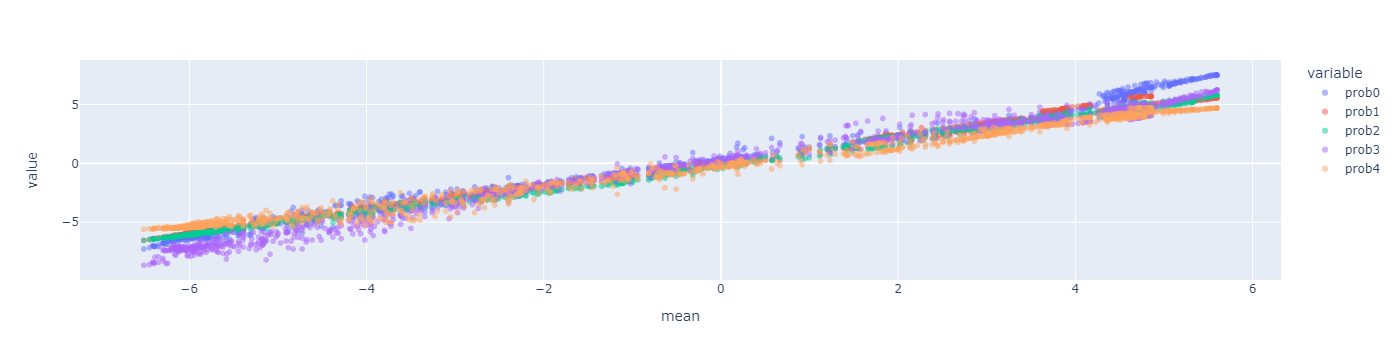

In [127]:
logit = lambda p: np.log(p / (1-p))
df_log = (df_test_prob
          .assign(mean=df_test_prob.mean(axis=1))
          .applymap(logit)
          .sort_values(by='mean')
          #.drop(columns='mean')
          #.transpose()
         )
df_log
px.scatter(df_log, x='mean', y=[f'prob{i}' for i in range(5)], opacity=0.5)

### CNN

In [26]:
members = [
    'cv/cv/fused_sharp/0/0/CNN',
    '////1/',
    '////2/',
    '////3/',
    '////4/',
]

levelone = LevelOneData(members, get_train=False)

dict_values(['cv', 'cv', 'fused_sharp', '0', '0', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '1', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '2', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '3', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '4', 'CNN'])


In [27]:
df_train_list = [dfs['train'] for dfs in levelone.dfs]
df_val_list = [dfs['val'] for dfs in levelone.dfs]
df_test_list = [dfs['test'] for dfs in levelone.dfs]
df_test_prob = pd.concat([df['prob'].rename(f'prob{i}')
                          for i, df in enumerate(df_test_list)], axis=1)

/home/zeyusun/.conda/envs/arnet2/lib/python3.8/site-packages/plotly/express/_core.py:1222: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



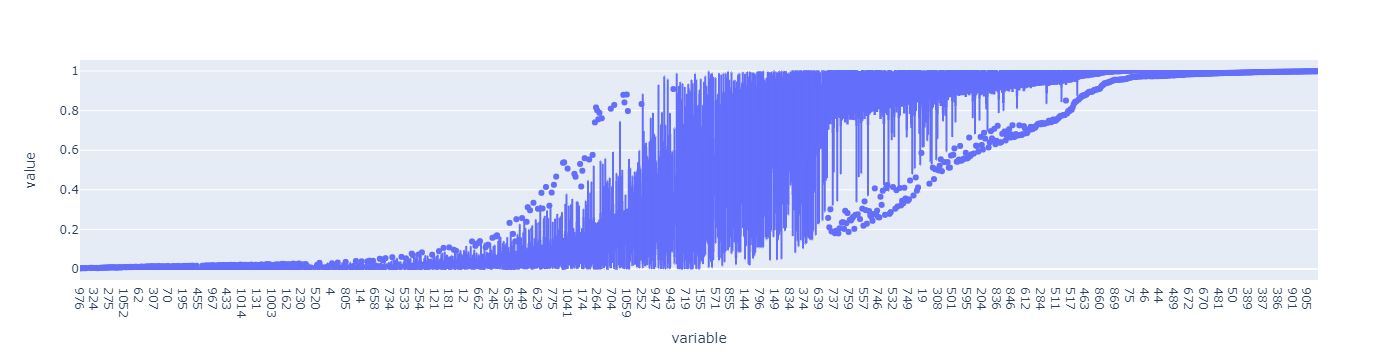

In [28]:
df_box = (df_test_prob
          .assign(mean=df_test_prob.mean(axis=1))
          .sort_values(by='mean')
          .drop(columns=['mean'])
          .transpose())
px.box(df_box) #jitter=False)

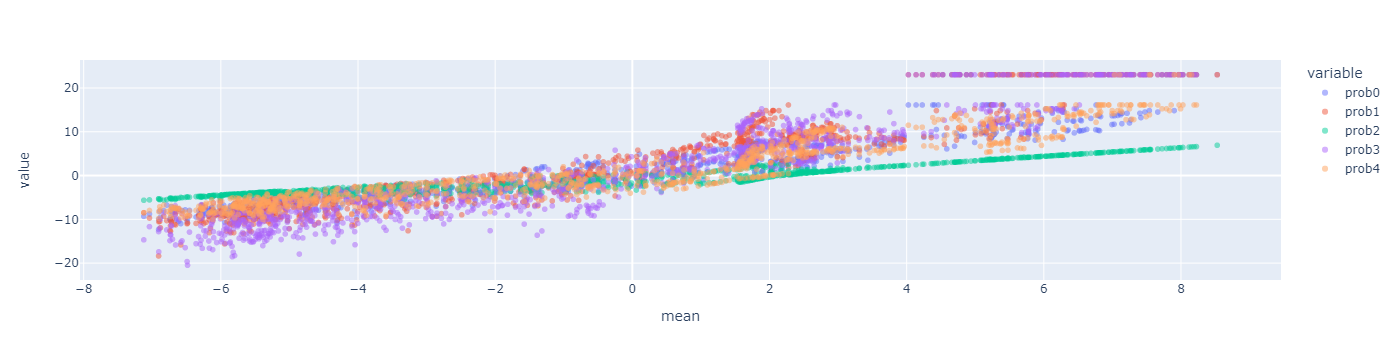

In [134]:
logit = lambda p: np.log(p / (1-p+1e-10))
df_log = (df_test_prob
          .assign(mean=df_test_prob.mean(axis=1))
          .applymap(logit)
          .sort_values(by='mean')
          #.drop(columns='mean')
          #.transpose()
         )
df_log
px.scatter(df_log, x='mean', y=[f'prob{i}' for i in range(5)], opacity=0.5)

### CNN on SHARP

In [5]:
members = [
    'cv/cv/sharp/0/0/CNN',
    '////1/',
    '////2/',
    '////3/',
    '////4/',
]

levelone = LevelOneData(members, get_train=False)

dict_values(['cv', 'cv', 'sharp', '0', '0', 'CNN'])
Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
221 2021-09-09 17:32:31.575000+00:00                  cv
dict_values(['cv', 'cv', 'sharp', '0', '1', 'CNN'])
dict_values(['cv', 'cv', 'sharp', '0', '2', 'CNN'])
dict_values(['cv', 'cv', 'sharp', '0', '3', 'CNN'])
dict_values(['cv', 'cv', 'sharp', '0', '4', 'CNN'])


In [56]:
df_train_list = [dfs['train'] for dfs in levelone.dfs]
df_val_list = [dfs['val'] for dfs in levelone.dfs]
df_test_list = [dfs['test'] for dfs in levelone.dfs]
#df_test_prob = pd.concat([df['prob'].rename(f'prob{i}')
#                          for i, df in enumerate(df_test_list)], axis=1)
df_test_combined = (df_test_list[0]
                    #.rename(columns={'prob': 'prob0'})
                    .drop(columns=['prob'])
                    .assign(**{f'prob{i}': df_test_list[i]['prob'] for i in range(5)})
                   )
df_test_combined

prefix  arpnum              t_start                t_end  label flares  \
0      HARP     241  2010-11-05 09:36:00  2010-11-06 09:36:00  False    NaN   
1      HARP     241  2010-11-05 16:00:00  2010-11-06 16:00:00  False    NaN   
2      HARP     259  2010-11-19 20:48:00  2010-11-20 20:48:00  False    NaN   
3      HARP     259  2010-11-20 17:36:00  2010-11-21 17:36:00  False    NaN   
4      HARP     259  2010-11-26 17:36:00  2010-11-27 17:36:00  False    NaN   
...     ...     ...                  ...                  ...    ...    ...   
1083   HARP    7452  2020-10-08 19:12:00  2020-10-09 19:12:00  False    NaN   
1084   HARP    7452  2020-10-10 19:12:00  2020-10-11 19:12:00  False    NaN   
1085   HARP    7452  2020-10-11 11:12:00  2020-10-12 11:12:00  False    NaN   
1086   HARP    7452  2020-10-12 20:48:00  2020-10-13 20:48:00  False    NaN   
1087   HARP    7452  2020-10-13 20:48:00  2020-10-14 20:48:00  False    NaN   

     bad_img_idx  HEIGHT  WIDTH           SUM  ...  FLARE_INDEX         AREA  \
0           [-2]      92    203  22826.222656  ...          0.0  3923.516113   
1           [-6]      92    203  27990.175781  ...          0.0  3945.811523   
2             []     107    168  20721.845703  ...          0.0  6099.301758   
3             []     107    168  25945.353516  ...          0.0  6277.690918   
4             []     107    168  36199.320312  ...          0.0   908.390442   
...          ...     ...    ...           ...  ...          ...          ...   
1083          []      43    121   1356.689453  ...          0.0  1293.604980   
1084       [-12]      43    121   3117.289062  ...          0.0  2217.553223   
1085          []      43    121   3810.162109  ...          0.0  2373.965088   
1086        [-2]      43    121   1851.382812  ...          0.0  2032.333862   
1087        [-2]      43    121   8791.486328  ...          0.0  1178.410645   

           USFLUXL  MEANGBL   R_VALUE     prob0     prob1     prob2     prob3  \
0     6.062487e+21   19.805 -0.094560  0.006181  0.013650  0.000012  0.005261   
1     6.026058e+21   19.496 -0.094560  0.011755  0.017695  0.000052  0.006401   
2     1.004505e+22   20.988 -0.094560  0.000008  0.004982  0.001397  0.000962   
3     1.030289e+22   21.911  2.256388  0.000005  0.008413  0.000397  0.001632   
4     1.635712e+21   13.945  2.294696  0.001154  0.000637  0.000089  0.000880   
...            ...      ...       ...       ...       ...       ...       ...   
1083  2.204893e+21   22.663  2.268880  0.015815  0.157720  0.001408  0.009232   
1084  3.886138e+21   23.586 -0.094560  0.080213  0.059102  0.028680  0.003601   
1085  4.002675e+21   22.431 -0.094560  0.059976  0.034197  0.050144  0.003984   
1086  2.661769e+21   17.951 -0.094560  0.000009  0.004718  0.000005  0.000112   
1087  1.601642e+21   16.952 -0.094560  0.000010  0.005002  0.000020  0.000191   

         prob4  
0     0.000155  
1     0.000203  
2     0.000008  
3     0.000004  
4     0.000173  
...        ...  
1083  0.007592  
1084  0.028194  
1085  0.052328  
1086  0.000023  
1087  0.000017  

[1088 rows x 21 columns]

In [68]:
df_box = (df_test_combined
          .assign(mean=df_test_prob.mean(axis=1))
          .sort_values(by=['label', 'mean'])
          .reset_index(drop=True)
         )
fig = go.Figure()
for i in range(5):
    fig.add_trace(go.Scatter(x=df_box.index,
                             y=df_box[f'prob{i}'],
                             mode='markers',
                             #marker_size=3,
                             opacity=0.6,
                             name=f'prob{i}'))

mean_x = df_box.index.values
mean_y = df_box['mean'].values
# Hack: add a point in the center with None value to break the curve
idx = len(mean_x) // 2 # start of the latter half
mean_x = np.insert(mean_x, idx, idx-0.5)
mean_y = np.insert(mean_y, idx, None)

fig.add_trace(go.Scatter(x=mean_x, y=mean_y, name='mean'))

fig = go.FigureWidget(fig)
fig

FigureWidget({
    'data': [{'mode': 'markers',
              'name': 'prob0',
              'opacity': 0.6,
 …

In [63]:
dfs = []
for i in range(5):
    inds = fig.data[i].selectedpoints
    if inds is None:
        continue
    inds = list(inds)
    df = df_box.iloc[inds].assign(model_query=f'cv/cv/sharp/0/{i}/CNN')
    dfs.append(df)
# if not dfs:
#     df = pd.DataFrame()
# else:
#     df = pd.concat(dfs)
df = pd.concat(dfs) if dfs else pd.DataFrame()
df

prefix  arpnum              t_start                t_end  label  \
611   HARP    4639  2014-10-07 08:00:00  2014-10-08 08:00:00   True   
611   HARP    4639  2014-10-07 08:00:00  2014-10-08 08:00:00   True   

                                                flares bad_img_idx  HEIGHT  \
611  C1.0|C2.1|C2.0|C3.8|M1.3|M1.4|C1.6|C1.3|C4.2|C...        [-9]     159   
611  C1.0|C2.1|C2.0|C3.8|M1.3|M1.4|C1.6|C1.3|C4.2|C...        [-9]     159   

     WIDTH          SUM  ...       USFLUXL  MEANGBL   R_VALUE     prob0  \
611    598  408221.5625  ...  2.823799e+22   21.373  3.108326  0.318909   
611    598  408221.5625  ...  2.823799e+22   21.373  3.108326  0.318909   

        prob1     prob2    prob3     prob4      mean          model_query  
611  0.215186  0.026456  0.76934  0.290729  0.324124  cv/cv/sharp/0/2/CNN  
611  0.215186  0.026456  0.76934  0.290729  0.324124  cv/cv/sharp/0/3/CNN  

[2 rows x 23 columns]

In [66]:
df_box['t_start'].iloc[0]

'2016-04-28 16:00:00'

In [67]:
df_box.loc[
    (df_box['arpnum'] == 4639) &
    (df_box['t_end'] == '2014-10-08 08:00:00')
]

prefix  arpnum              t_start                t_end  label  \
611   HARP    4639  2014-10-07 08:00:00  2014-10-08 08:00:00   True   

                                                flares bad_img_idx  HEIGHT  \
611  C1.0|C2.1|C2.0|C3.8|M1.3|M1.4|C1.6|C1.3|C4.2|C...        [-9]     159   

     WIDTH          SUM  ...          AREA       USFLUXL  MEANGBL   R_VALUE  \
611    598  408221.5625  ...  18575.070312  2.823799e+22   21.373  3.108326   

        prob0     prob1     prob2    prob3     prob4      mean  
611  0.318909  0.215186  0.026456  0.76934  0.290729  0.324124  

[1 rows x 22 columns]

In [64]:
df.to_csv('_selected.csv')

* prob0 and prob1 tend to overforecast than the avg model.
* prob4 tend to underforecast than the avg model.
* Since the mistakes are mostly miss detection, overforecasting tends to have better performance.

Highlight `mean`, `prob1`(or `prob0`), and `prob4`. Focus on the beginning right half. There is something that `prob1` found in the images of those positive samples that are neglected by `prob4`.

You don't even need to compare CNN trained on different datasets. Cross-validation itself gives so much variations that is worth investigating.

Feature request:
* Rewrite sorted prediction plot as a function, taking predictions of different models as inputs.
* on_hover: all points from other active regions fade out.
* on_click:
    * the image of the sample is displayed, together with the visual attributions
    * the keyword time series of that active region is displayed, with the sampled period highlighted.

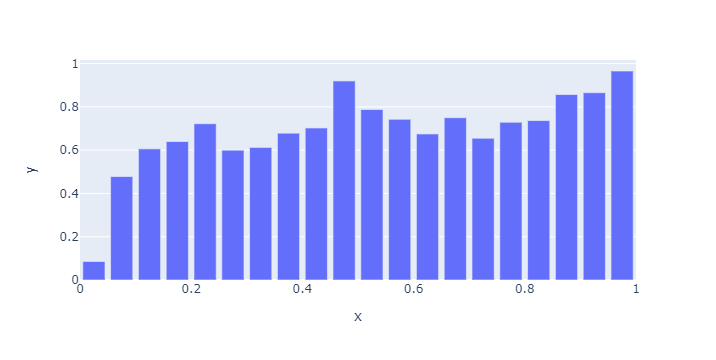

In [62]:
df_hist = df_box.T
df_hist = pd.melt(df_hist,
                  id_vars=['label'],
                  value_vars=[f'prob{i}' for i in range(5)])
hist, bin_edges = np.histogram(df_hist['value'], bins=20)
pos_hist, _ = np.histogram(df_hist.loc[df_hist['label'], 'value'], bins=bin_edges)
bins = 0.5 * (bin_edges[:-1] + bin_edges[1:])
posterior = pos_hist / hist
px.bar(x=bins, y=posterior)
#px.histogram(df_hist, x='value', color='label', barmode='relative')

* I reinvented the reliability diagram.
* Although in this case, it is calculated based on all the validation sets in cross-validation, and hence should be a better estimate to the out-of-sample reliability diagram.
* Conclusion: CNN is underforecasting across the entire output probability range from 0 to 1. Pictorially, draw an arbitrary horizontal line in the sorted prediction plot, the intersection with the right is always longer than the left.

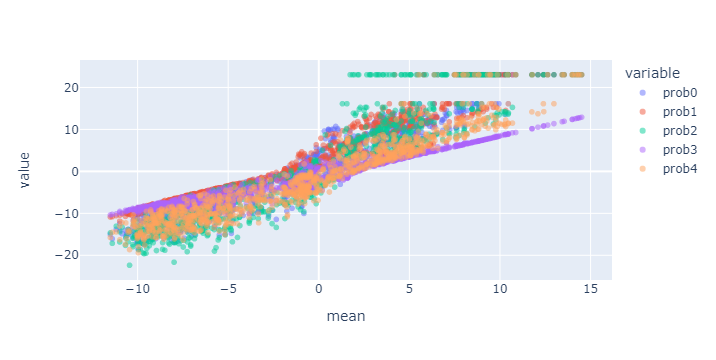

In [138]:
logit = lambda p: np.log(p / (1-p+1e-10))
df_log = (df_test_prob
          .assign(mean=df_test_prob.mean(axis=1))
          .applymap(logit)
          .sort_values(by='mean')
          #.drop(columns='mean')
          #.transpose()
         )
df_log
px.scatter(df_log, x='mean', y=[f'prob{i}' for i in range(5)], opacity=0.5)

* How to fuse the models trained in cross validation?
    * Refit is unreasonable (also impractical) for deep learning models
    * Select the model with the best validation score
    * ... with the best mean(train, val) score (not weighted by split size)
    * Do not fuse. Use all of them on the test set and take the mean prediction.
        * We already have this results above in the sorted prediction plot
    * Fit a stacking ensemble:
        * Problem: We do not have a common out-of-sample dataset; the val splits are disjoint.
        * We could held out, once again, some samples in the training set as the common validation set and use it to fit the meta-learner.
            * Select-best
            * Stacking with TSS criterion
            * Stacking with meta-features

In [205]:
tss = {
    'val': [],
    'test': [],
}
for i in range(5):
    run = retrieve_run(f'cv/cv/fused_sharp/0/{i}/CNN')
    ckpt_info = (run['tags.checkpoint']
                .split('/')[-1]
                .replace('.ckpt', '')
                .replace('-', '=')
                .split('='))
    step: str = ckpt_info[3]
    tss['val'].extend(retrieve_metrics(
        run['run_id'], 'validation0/tss', steps=[step]))
    tss['test'].extend(retrieve_metrics(
        run['run_id'], 'validation1/tss', steps=[step]))

Select iloc slice(None, None, None) from 
                         start_time tags.mlflow.runName
40 2021-09-09 17:32:31.575000+00:00                  cv


In [207]:
# Useless
from collections import defaultdict
tss = defaultdict(list)
for i in range(5):
    run = retrieve_run(f'cv/cv/fused_sharp/0/{i}/CNN')
    ckpt_info = (run['tags.checkpoint']
                .split('/')[-1]
                .replace('.ckpt', '')
                .replace('-', '=')
                .split('='))
    step: str = ckpt_info[3]
    tss['split'].append(i)
    tss['step'].append(int(step))
    val_tss = retrieve_metrics_all(run_id, 'validation0/tss')
    
    tss['val_best'].append(retrieve_metrics(
        run['run_id'], 'validation0/tss', steps=[step])[0])
    tss['test_best'].append(retrieve_metrics(
        run['run_id'], 'validation1/tss', steps=[step])[0])
    tss['val'].append(retrieve_metrics(
        run['run_id'], 'validation0/tss'))
    tss['test'].append(retrieve_metrics(
        run['run_id'], 'validation1/tss'))

NameError: name 'run_id' is not defined

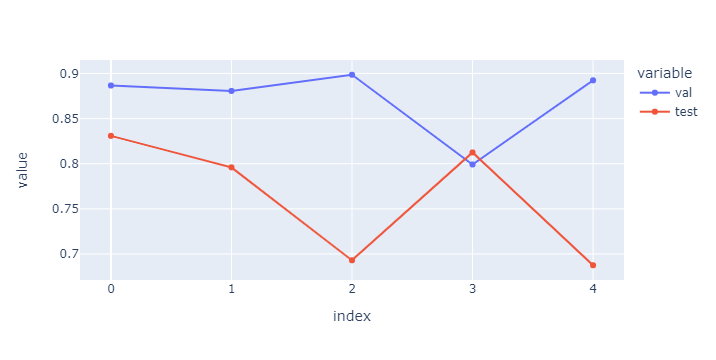

In [206]:
df_tss = pd.DataFrame(tss)
df_tss
px.line(df_tss, x=df_tss.index, y=df_tss.columns, markers='o')

* Selecting the best validation should be at least less possible to get a bad test set performance.
* Not so much for fused_sharp/seed=0/val_split=0

## Stacking (with cv)

In [2]:
members = [
    'cv/cv/fused_sharp/0/0/CNN',
    '////1/',
    '////2/',
    '////3/',
    '////4/',
]
levelone_cv_CNN = LevelOneData(members, get_train=False)
X_val_CNN, y_val_CNN, df_val_CNN = levelone_cv_CNN.combine_split('val', return_df=True)

dict_values(['cv', 'cv', 'fused_sharp', '0', '0', 'CNN'])
Select iloc slice(None, None, None) from 
                          start_time tags.mlflow.runName
125 2021-09-09 17:32:31.575000+00:00                  cv
dict_values(['cv', 'cv', 'fused_sharp', '0', '1', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '2', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '3', 'CNN'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '4', 'CNN'])


In [3]:
members = [
    'cv/cv/fused_sharp/0/0/LSTM',
    '////1/',
    '////2/',
    '////3/',
    '////4/',
]
levelone_cv_LSTM = LevelOneData(members, get_train=False)
X_val_LSTM, y_val_LSTM, df_val_LSTM = levelone_cv_LSTM.combine_split('val', return_df=True)

dict_values(['cv', 'cv', 'fused_sharp', '0', '0', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '1', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '2', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '3', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '4', 'LSTM'])


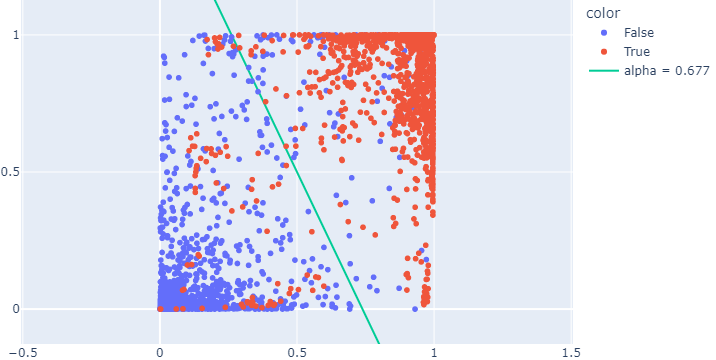

In [4]:
X_val = np.stack((X_val_LSTM, X_val_CNN)).T
assert np.all(y_val_LSTM == y_val_CNN)
y_val = y_val_LSTM
df_val = df_val_CNN

ml = MetaLearner(criterion='tss', mode='max')
ml.fit(X_val, y_val)
plot_level_one_naive(X_val, y_val, alpha=ml.alpha, meta=df_val)

dict_values(['cv', 'cv', 'fused_sharp', '0', '4', 'LSTM'])
dict_values(['cv', 'cv', 'fused_sharp', '0', '4', 'CNN'])


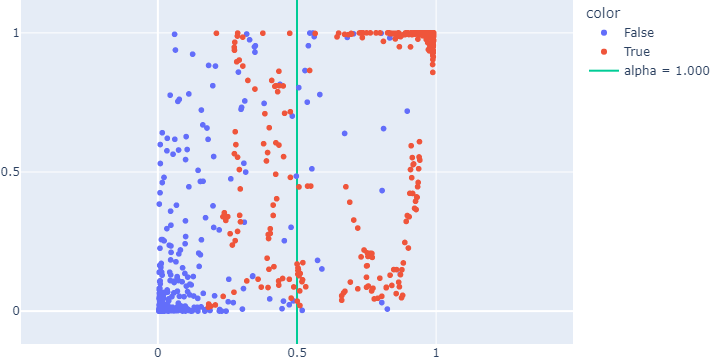

In [71]:
val_split = 4
members = [
    f'cv/cv/fused_sharp/0/{val_split}/LSTM',
    f'cv/cv/fused_sharp/0/{val_split}/CNN'
]
levelone_cv = LevelOneData(members, get_train=False)
_, _, _ = levelone_cv.get_split('val', return_df=True)
X_test, y_test, df_test = levelone_cv.get_split('test', return_df=True)

# X_test_list = [None] * 5
# for val_split in range(5):
#     members = [
#         f'cv/cv/fused_sharp/0/{val_split}/LSTM',
#         f'cv/cv/fused_sharp/0/{val_split}/CNN'
#     ]
#     levelone_cv = LevelOneData(members, get_train=False)
#     _, _, _ = levelone_cv.get_split('val', return_df=True)
#     X_test_list[val_split], y_test, df_test = levelone_cv.get_split('test', return_df=True)
# X_test = sum(X_test_list) / 5

ml_test = MetaLearner(criterion='tss', mode='max')
ml_test.fit(X_test, y_test)
plot_level_one_naive(X_test, y_test, alpha=ml_test.alpha, meta=df_test)

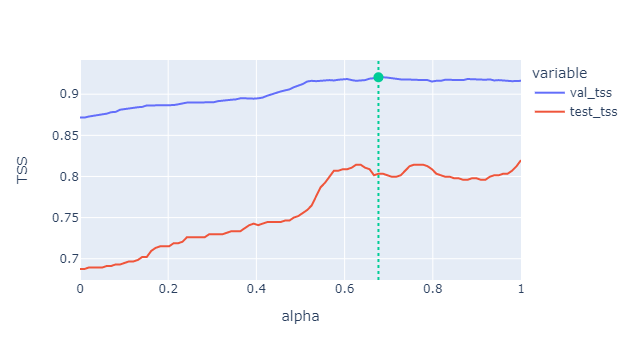

In [86]:
alphas = np.linspace(0, 1, 100)
df_alpha = pd.DataFrame({
    'alpha': alphas,
    'val_tss': [m['tss'] for m in ml.metrics],
    'test_tss': [m['tss'] for m in ml_test.metrics],
})
fig = px.line(df_alpha, x='alpha', y=['val_tss', 'test_tss'], labels={'value': 'TSS'})
idx = np.argmax(df_alpha['val_tss'])
fig.add_trace(go.Scatter(x=[alphas[idx]], y=[ml.metrics[idx]['tss']], marker_size=10, showlegend=False))
fig.add_vline(x=alphas[idx], line_color=px.colors.qualitative.Plotly[2], line_dash='dot')

In [13]:
runs.loc[
    (runs['dataset'] == 'fused_sharp') &
    (runs['split'] == str(val_split))
]

database      dataset estimator seed       ACC       AUC       TSS  \
107  M_Q_24hr  fused_sharp       CNN    0  0.846507  0.969039  0.693015   
112  M_Q_24hr  fused_sharp      LSTM    0  0.916360  0.988528  0.832721   

          HSS       BSS split  
107  0.693015  0.325913     2  
112  0.832721  0.743160     2

## Venn

## Common characteristics (any conclusions will do)
* Parallel coordinate plot and Histograms?
* Guided Grad-CAM?
* Embedding space? Nearest neighbors.